

    Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

    This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
    Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

        Normal (N),
        Diabetes (D),
        Glaucoma (G),
        Cataract (C),
        Age related Macular Degeneration (A),
        Hypertension (H),
        Pathological Myopia (M),
        Other diseases/abnormalities (O)



In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms


# Importation du dataset depuis Kaggle


In [2]:
pip install kaggle

In [3]:
import os
from google.colab import files

files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle (1).json to kaggle (1).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
 98% 1.60G/1.62G [00:16<00:00, 235MB/s]
100% 1.62G/1.62G [00:16<00:00, 104MB/s]


In [5]:

!unzip -q -o ocular-disease-recognition-odir5k.zip


In [6]:
current_working_directory = os.getcwd()
print(current_working_directory)

/content


In [7]:
contents = os.listdir(current_working_directory)
print(contents)


['.config', 'kaggle (1).json', 'ocular-disease-recognition-odir5k.zip', 'preprocessed_images', 'full_df.csv', 'ODIR-5K', 'sample_data']


#Analyse statistique des données pour comprendre la répartition des différentes classes.

In [8]:
df = pd.read_csv("full_df.csv")

In [9]:
print(df.columns)

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')


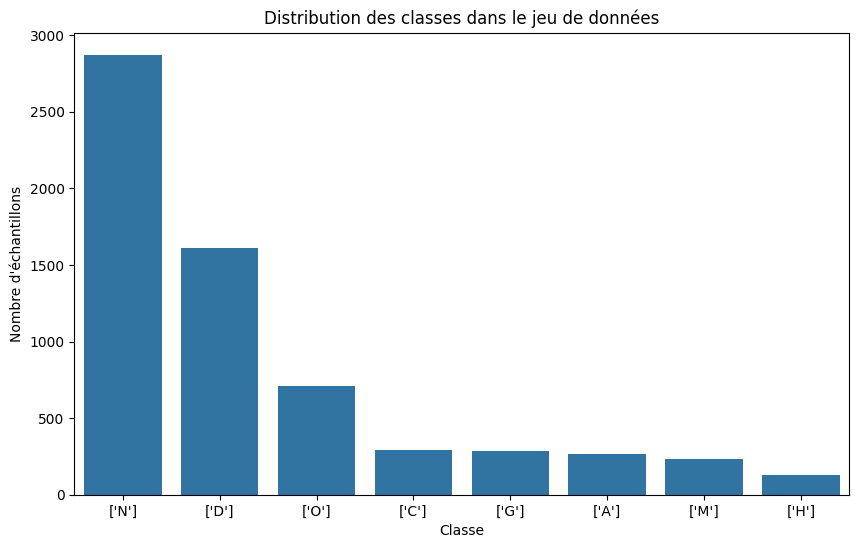

Distribution des classes :
 labels
['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: count, dtype: int64


In [10]:
# Afficher les premières lignes du jeu de données pour comprendre sa structure
df.head()
class_distribution = df['labels'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(x='labels', data=df, order=class_distribution.index)
plt.title('Distribution des classes dans le jeu de données')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.show()
print("Distribution des classes :\n", class_distribution)


In [11]:
df.head()


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


#Prétraitement des Données : Normalisation et redimensionnement des images,et Encodage des classes, Data Analyse



In [12]:
pip install opencv-python


In [13]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 17.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

In [14]:
#We drop the letter and use only one hot encoding representation of each disease
data = df.drop(columns=['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'labels'])

data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [15]:

classes = { 0: "Normal",
            1: "Diabetes",
            2: "Glaucoma",
            3: "Cataract",
            4: "Age related Macular Degeneration",
            5: "Hypertension",
            6: "Pathological Myopia",
            7: "Other diseases/abnormalities"
          }



In [16]:
import json  # Ajoutez cette ligne pour importer le module json

In [17]:
# listes des representation one hot des mes 8 classes
targets = np.array(data["target"].apply(lambda x: json.loads(x)).tolist())
targets.shape



(6392, 8)

In [18]:
print(targets) #liste des targets

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [19]:
# creating the dataset
echantillons_per_class = np.sum(targets, axis=0)
print(echantillons_per_class)
print("Shape de mes data : ",data.shape) #10 colonnes, 6392 lignes

[2873 1608  284  293  266  128  232  708]
Shape de mes data :  (6392, 10)


In [20]:
img_folder = "preprocessed_images"
img_dir = target_folder_path = os.path.join(current_working_directory, img_folder)

In [21]:
data["class_name"] = np.argmax(targets, axis=1).tolist()
data["class_name"] = data["class_name"] .replace(classes)

data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,target,filename,class_name
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,Normal
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,Normal
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,Diabetes
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,Diabetes
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,Diabetes


In [22]:
import cv2

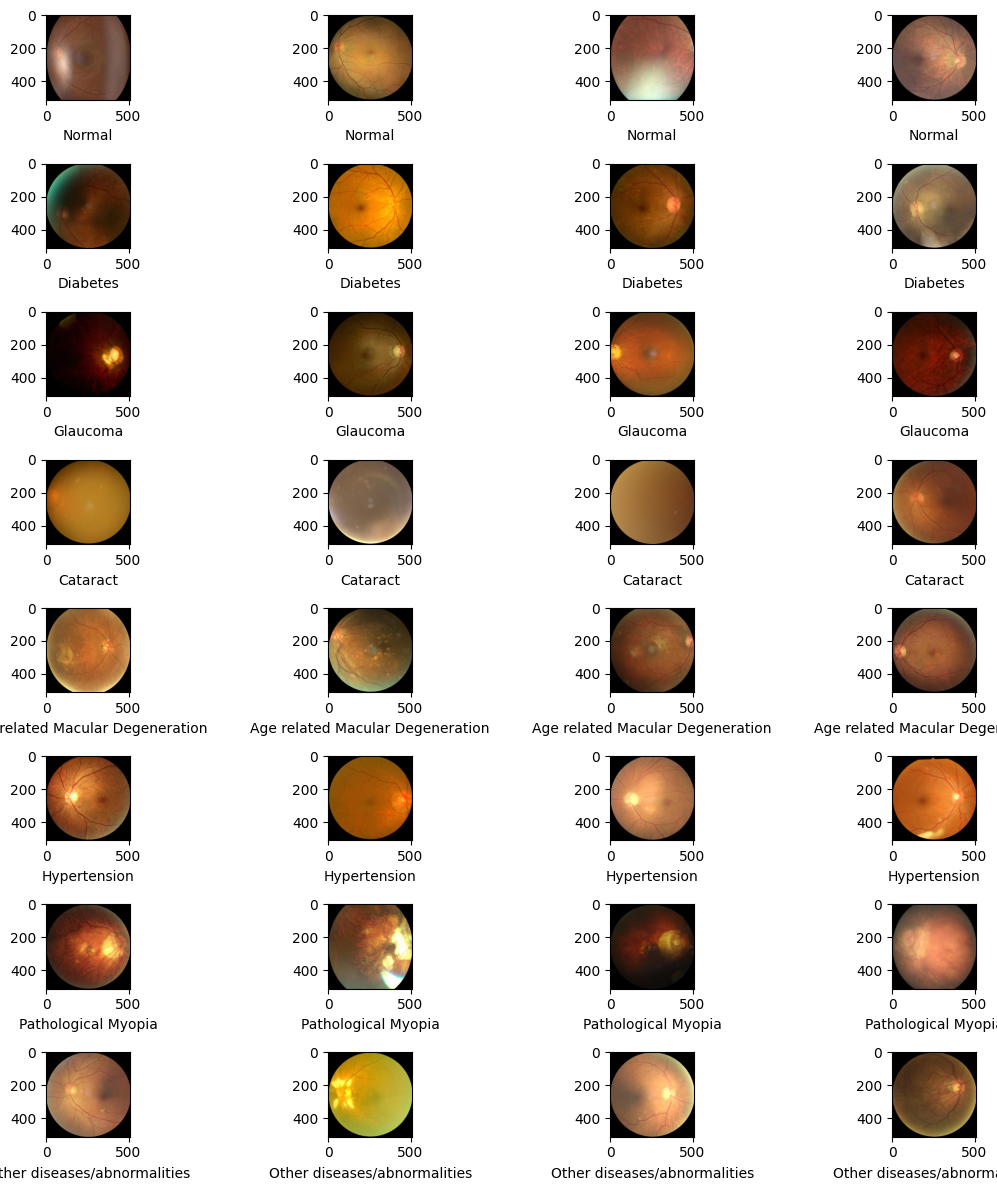

In [23]:
plt.figure(figsize=(12, 12))
class_subsets = [(class_name, data.loc[data.class_name == class_name].sample(n=4)) for class_name in classes.values()]

# Générer une liste de tuples contenant (image_rgb, class_name) pour chaque image dans chaque subset
images_with_labels = [
    (cv2.cvtColor(cv2.imread(os.path.join(img_dir, img)), cv2.COLOR_BGR2RGB), class_name)
    for class_name, subset in class_subsets
    for img in subset.filename.to_list()
]

# Afficher les images
[
    (plt.subplot(8, 4, i + 1), plt.imshow(image_rgb, aspect=1), plt.xlabel('{}'.format(class_name)))
    for i, (image_rgb, class_name) in enumerate(images_with_labels)
]

plt.tight_layout()
plt.show()

In [24]:
import cv2
import os
import numpy as np

# Extraction des noms de fichiers et des cibles
filenames = data['filename'].values
targets = data['target'].values

# Définition de la taille de l'image
size = (224, 224)

# Fonction de prétraitement des images
def preprocess_image(filename):
    image_path = os.path.join(img_dir, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(image, size)
    normalized_image = resized_image / 255.0
    return normalized_image

# Utilisation de la compréhension de liste pour charger et prétraiter les images
images = np.array([preprocess_image(filename) for filename in filenames])





In [25]:
print(images.shape)
print(targets.shape)

(6392, 224, 224)
(6392,)


In [26]:
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,target,filename,class_name
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,Normal
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,Normal
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,Diabetes
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,Diabetes
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,Diabetes


In [27]:
processed_labels = data
processed_labels.to_csv('/content/labels_clean.csv', index=False)

processed_labels.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,target,filename,class_name
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,Normal
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,Normal
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,Diabetes
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,Diabetes
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,Diabetes


In [28]:
contents = os.listdir(current_working_directory)
print(contents)


['.config', 'labels_clean.csv', 'kaggle (1).json', 'ocular-disease-recognition-odir5k.zip', 'preprocessed_images', 'full_df.csv', 'ODIR-5K', 'sample_data']


In [29]:
df_clean = pd.read_csv("labels_clean.csv")
df_clean.head()
df_clean.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'filepath',
       'target', 'filename', 'class_name'],
      dtype='object')

#Construction du Modèle

Choix de l'Architecture : ResNet Configuration du Modèle en PyTorch


In [30]:
import json
import os
import pickle
import random
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import pytorch_lightning as pl
from skimage import io, transform
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms, utils
from torchvision.utils import make_grid
from pytorch_lightning import Trainer, seed_everything


In [31]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [32]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.0 MB/s eta 0:00:00


In [33]:
!nvidia-smi

Sun Jun 23 19:56:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Définition du modèle

In [34]:
import timm

In [35]:
import numpy as np
from torchvision import transforms

class RandomCrop(object):
    """Crop randomly the image in a sample."""

    def __init__(self, output_size):
        assert isinstance(output_size, (int,tuple))
        if isinstance(output_size, int):
            self.output_size = output_size
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        h, w = image.shape[:2]
        new_h = new_w = self.output_size

        if new_h >= h or new_w >= w:
            raise ValueError(f"Requested crop size ({new_h}, {new_w}) larger than input image size ({h}, {w})")
        # Calculate random top and left coordinates for cropping
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)


        # Perform cropping
        image = image[top:top + new_h, left:left + new_w]


        return {'image': image, 'labels': labels}






In [36]:

class ToTensor(object):
    """convert ndarrays in sample to tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(label)}

In [37]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        resized_image = transform.resize(image, (new_h, new_w))

        image_clipped = np.clip(resized_image, 0, 255)  # Clipper les valeurs pour les maintenir dans la plage [0, 255]
        image_normalized = image_clipped / 255.0  # Normaliser les valeurs pour les ramener dans la plage [0.0, 1.0]


        return {'image': image_normalized, 'labels': labels}


In [38]:
# Custom Dataset
class OcularDiseaseRecognition(Dataset):
    def __init__(self, label_csv_file, root_dir, transform=None):
        self.labels_frame = pd.read_csv(label_csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #/content/ODIR-5K/ODIR-5K/Training Images/
        file_path = self.labels_frame.iloc[idx]['filepath']
        image_name = os.path.basename(file_path)  # Récupère seulement le nom du fichier
        path = os.path.join("ODIR-5K/ODIR-5K/Training Images/", image_name)

        image = io.imread(path)


        image = image.astype(np.float32)  # Assurez-vous que l'image est en float32
        target = self.labels_frame.iloc[idx, 8]
        target = np.array(json.loads(target))
        sample = {'image': image, 'labels': target}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [48]:
# Custom Model using EfficientNet
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import Accuracy

import time
class CustomEfficientNet(pl.LightningModule):
    def __init__(self, num_classes=8):
        super(CustomEfficientNet, self).__init__()
        '''timm_args = {
                'in_chans': 3,
                'features_only': True,
                'exportable': True,
            }'''

        self.model = timm.create_model('efficientnet_b0', pretrained=True)

        in_features = self.model.classifier.in_features  # Récupère le nombre d'entrées de la couche actuelle
        self.model.classifier = nn.Linear(in_features, num_classes)  # Remplace la dernière couche linéaire

        self.model = self.model.to(torch.float32)  # Assurez-vous que le modèle utilise le bon type de données
        self.criterion = nn.CrossEntropyLoss()
        self.train_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)




    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['labels']

        outputs = self(images)
        labels = labels.argmax(dim=1)
        loss = F.nll_loss(outputs, labels)
        acc = self.train_accuracy(outputs, labels)
        self.log('train_loss', loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['labels']
        outputs = self(images)
        labels = labels.argmax(dim=1)


        loss = F.nll_loss(outputs, labels)
        acc = self.val_accuracy(outputs, labels)
        self.log('val_loss', loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, on_step=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        return optimizer



In [59]:
# Data Module remains the same
# Helper function to unnormalize and display an image
def imshow(img):
    # Unnormalize the image if it was normalized (assuming mean=0.5, std=0.5)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

class OcularDiseaseDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, label_csv_file, batch_size=32, valid_size=0.2, test_size=0.2, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.label_csv_file = label_csv_file
        self.batch_size = batch_size
        self.valid_size = valid_size
        self.test_size = test_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        full_data = OcularDiseaseRecognition(
            label_csv_file=self.label_csv_file,
            root_dir=self.data_dir,
            transform=transforms.Compose([Rescale(512),RandomCrop(256), ToTensor()])
        )


        num_train = len(full_data)
        indices = list(range(num_train))
        np.random.shuffle(indices)
        val_split = int(np.floor(self.valid_size * num_train))
        test_split = int(np.floor(self.test_size * num_train))
        test_idx, valid_idx, train_idx = indices[:test_split], indices[test_split: test_split + val_split], indices[test_split + val_split:]

        self.train_sampler = SubsetRandomSampler(train_idx)
        self.valid_sampler = SubsetRandomSampler(valid_idx)
        self.test_sampler = SubsetRandomSampler(test_idx)
        self.full_data = full_data
        sample = self.full_data[0]
        print(f"labels shape before give them to dataloaders {sample['labels'].shape} and image {sample['image'].shape}")
        imshow(sample['image'])

    def train_dataloader(self):
        return DataLoader(self.full_data, batch_size=self.batch_size, sampler=self.train_sampler, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.full_data, batch_size=self.batch_size, sampler=self.valid_sampler, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.full_data, batch_size=self.batch_size, sampler=self.test_sampler, num_workers=self.num_workers)

    def get_dataloader(self, mode='train'):
        if mode == 'train':
            return self.train_dataloader()
        elif mode == 'val':
            return self.val_dataloader()
        elif mode == 'test':
            return self.test_dataloader()
        else:
            raise ValueError(f"Invalid mode {mode}. Choose from ['train', 'val', 'test'].")


# Define Pytorch Dataloader & Load Data

In [42]:
# Monter Google Drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# Initialize data module
data_dir = os.getcwd()
label_csv_file = 'labels_clean.csv'
data_module = OcularDiseaseDataModule(data_dir, label_csv_file)



labels shape before give them to dataloaders torch.Size([8]) and image torch.Size([3, 256, 256])


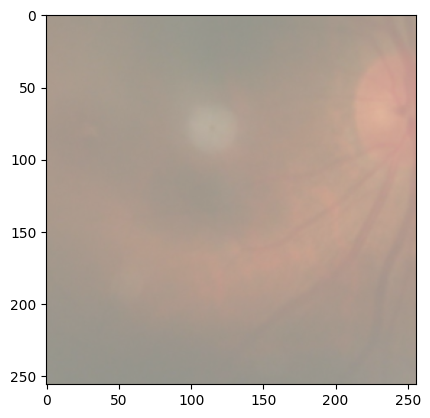

In [44]:
# Setup the data module
data_module.setup()

# Helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from Tensor image

# Function to visualize images
def visualize_images(dataloader, batch_size, title):
    dataiter = iter(dataloader)
    sample = next(dataiter)

    print(f"Sample image batch shape: {sample['image'].shape}")  # Debug print

    fig = plt.figure(figsize=(25, 4))
    for idx in range(batch_size):
        ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
        imshow(sample['image'][idx])
        ax.set_title(f"Label: {sample['labels'][idx].numpy()}")
    plt.suptitle(title)
    plt.show()



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Sample image batch shape: torch.Size([32, 3, 256, 256])


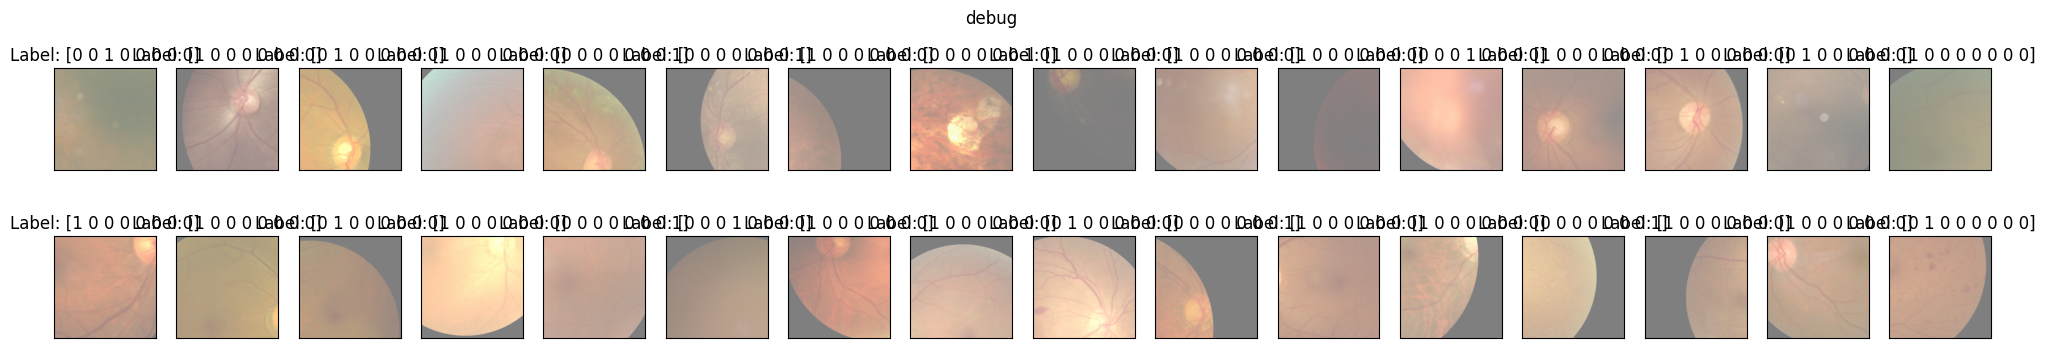

In [45]:
visualize_images(data_module.get_dataloader('train'), 32, 'debug')


In [55]:
# Define the logger
logger = TensorBoardLogger("tb_logs", name="my_model")

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints_ocular/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='max',
    verbose=True
)
early_stop_callback = EarlyStopping(
    monitor='val_acc',
    patience=30,
    mode='max',
    verbose=True
)

# Define the trainer
trainer = pl.Trainer(
    max_epochs=60,
    precision=16,  # Mixed precision training
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    check_val_every_n_epoch=1,
    log_every_n_steps=50,
    accelerator='gpu',
)

num_classes = 8
model = CustomEfficientNet(num_classes)


/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, datamodule=data_module)



INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 4.0 M  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.071    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


VALID STEP
VALID STEP


Training: |          | 0/? [00:00<?, ?it/s]

TRAINING STEP


In [51]:
data_dir = os.getcwd()
print(data_dir)

/content


In [57]:

best_model_path = "drive/My Drive/checks/best-checkpoint.ckpt"
trained_model = CustomEfficientNet.load_from_checkpoint(best_model_path, num_classes=8,map_location=torch.device('cpu'))


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.6.3 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/My Drive/checks/best-checkpoint.ckpt`


In [61]:
# Put the model in evaluation mode
trained_model.eval()
trained_model.freeze()

# Create the test dataloader
test_dataloader = data_module.test_dataloader()

# Make predictions
all_preds = []
all_labels = []

for batch in test_dataloader:
    images, labels = batch['image'], batch['labels']
    labels = labels.argmax(dim=1)
    outputs = trained_model(images)
    preds = torch.argmax(outputs, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Now you have all_preds and all_labels for the test set


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#EVAL AND CONFUSION MATRIX

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [67]:
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Précision
precision = precision_score(all_labels, all_preds, average='weighted')
print(f"Precision: {precision * 100:.2f}%")

# Recall
recall = recall_score(all_labels, all_preds, average='weighted')
print(f"Recall: {recall * 100:.2f}%")

# Score F1
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1 * 100:.2f}%")



Test Accuracy: 69.95%
Precision: 70.61%
Recall: 69.95%
F1 Score: 68.86%


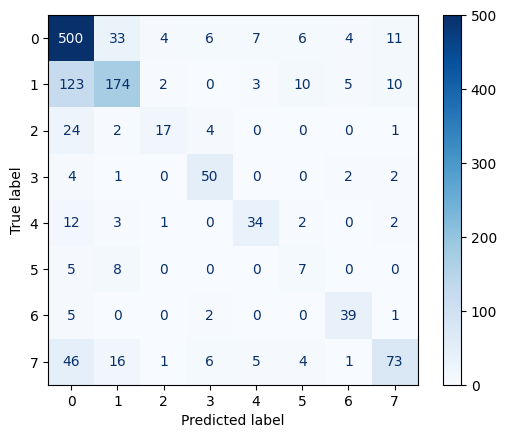

In [63]:
# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#TRAIN

#DATAVIZ
